In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import WeightedRandomSampler

# Tải dữ liệu từ file CSV
duong_dan_file = '/content/financial_fraud_detection_dataset.csv'
try:
    df = pd.read_csv(duong_dan_file)
    print("Dữ liệu đã được tải thành công.")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file tại đường dẫn {duong_dan_file}. Vui lòng kiểm tra lại đường dẫn.")
    df = None

Dữ liệu đã được tải thành công.


In [ ]:
if df is not None:
    print("\n5 dòng đầu tiên của dữ liệu:")
    display(df.head())

    print("\nThông tin về các cột và kiểu dữ liệu:")
    display(df.info())

    print("\nThống kê mô tả dữ liệu:")
    display(df.describe())


5 dòng đầu tiên của dữ liệu:


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash
0,T100000,2023-08-22T09:22:43.516168,ACC877572,ACC388389,343.78,withdrawal,utilities,Tokyo,mobile,False,NaN,NaN,-0.21,3.0,0.22,card,13.101.214.112,D8536477
1,T100001,2023-08-04T01:58:02.606711,ACC895667,ACC944962,419.65,withdrawal,online,Toronto,atm,False,NaN,NaN,-0.14,7.0,0.96,ACH,172.52.47.194,D2622631
2,T100002,2023-05-12T11:39:33.742963,ACC733052,ACC377370,2773.86,deposit,other,London,pos,False,NaN,NaN,-1.78,20.0,0.89,card,185.98.35.23,D4823498
3,T100003,2023-10-10T06:04:43.195112,ACC996865,ACC344098,1666.22,deposit,online,Sydney,pos,False,NaN,NaN,-0.60,6.0,0.37,wire_transfer,107.136.36.87,D9961380
4,T100004,2023-09-24T08:09:02.700162,ACC584714,ACC497887,24.43,transfer,utilities,Toronto,mobile,False,NaN,NaN,0.79,13.0,0.27,ACH,108.161.108.255,D7637601



Thông tin về các cột và kiểu dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971261 entries, 0 to 1971260
Data columns (total 18 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   transaction_id               object 
 1   timestamp                    object 
 2   sender_account               object 
 3   receiver_account             object 
 4   amount                       float64
 5   transaction_type             object 
 6   merchant_category            object 
 7   location                     object 
 8   device_used                  object 
 9   is_fraud                     bool   
 10  fraud_type                   object 
 11  time_since_last_transaction  float64
 12  spending_deviation_score     float64
 13  velocity_score               float64
 14  geo_anomaly_score            float64
 15  payment_channel              object 
 16  ip_address                   object 
 17  device_hash                  object 
dtypes: 

None


Thống kê mô tả dữ liệu:


,amount,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score
count,1.971261e+06,1.172151e+06,1.971260e+06,1.971260e+06,1.971260e+06
mean,3.589629e+02,1.619753e+00,7.138683e-04,1.049562e+01,4.997269e-01
std,4.704458e+02,3.577539e+03,1.000779e+00,5.767074e+00,2.886512e-01
min,1.000000e-02,-8.777814e+03,-5.030000e+00,1.000000e+00,0.000000e+00
25%,2.653000e+01,-2.563526e+03,-6.700000e-01,5.000000e+00,2.500000e-01
50%,1.384700e+02,1.007373e+00,0.000000e+00,1.000000e+01,5.000000e-01
75%,5.030300e+02,2.570445e+03,6.800000e-01,1.500000e+01,7.500000e-01
max,3.419970e+03,8.746169e+03,4.850000e+00,2.000000e+01,1.000000e+00


In [ ]:
print("Bắt đầu xử lý dữ liệu...")

# Tải dữ liệu từ file CSV, loại bỏ chỉ định dtype cho 'is_fraud' để pandas tự động xử lý
duong_dan_file = '/content/financial_fraud_detection_dataset.csv'
try:
    df_processed = pd.read_csv(duong_dan_file)
    print("Dữ liệu đã được tải lại thành công.")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file tại đường dẫn {duong_dan_file}. Vui lòng kiểm tra lại đường dẫn.")
    df_processed = None

if df_processed is not None:
    # Đảm bảo cột 'is_fraud' không chứa NaN trước khi chuyển đổi sang int
    if 'is_fraud' in df_processed.columns:
        initial_rows = len(df_processed)
        df_processed.dropna(subset=['is_fraud'], inplace=True)
        print(f"Đã loại bỏ {initial_rows - len(df_processed)} hàng có NaN trong cột 'is_fraud'.")

    # Xử lý các giá trị NaN một cách cẩn thận hơn để tránh mất lớp dữ liệu
    # 'fraud_type' có nhiều NaN, có thể điền bằng một giá trị đại diện cho 'không có loại gian lận'
    # REMOVED: df_processed['fraud_type'] = df_processed['fraud_type'].fillna('No_Fraud_Type')
    # REMOVED: print("Đã điền NaN trong 'fraud_type' bằng 'No_Fraud_Type'.")
    # Explanation: fraud_type is being dropped due to data leakage, so filling NaNs is not needed.

    # 'time_since_last_transaction' cũng có nhiều NaN, có thể điền bằng 0 hoặc median
    if 'time_since_last_transaction' in df_processed.columns:
        df_processed['time_since_last_transaction'] = df_processed['time_since_last_transaction'].fillna(0)
        print("Đã điền NaN trong 'time_since_last_transaction' bằng 0.")

    # Đối với các cột khác có rất ít NaN (như ip_address, device_hash), chúng ta có thể loại bỏ các hàng đó
    # hoặc điền bằng giá trị phổ biến nhất / 'unknown'.
    # Tuy nhiên, ip_address và device_hash sẽ bị loại bỏ khỏi tập X nên không cần xử lý NaN ở đây.
    # Sau khi xử lý các cột chính, loại bỏ các hàng còn NaN nếu có.
    # REMOVED: df_processed.dropna(inplace=True)
    # REMOVED: print("Đã loại bỏ các hàng còn lại chứa giá trị NaN sau khi xử lý các cột chính.")

    # Chuẩn hóa cột 'amount' (lưu ý: tên cột là 'amount' chứ không phải 'Amount')
    if 'amount' in df_processed.columns: # Kiểm tra để tránh lỗi nếu cột đã bị loại bỏ do NaN
        df_processed['NormalizedAmount'] = StandardScaler().fit_transform(df_processed['amount'].values.reshape(-1, 1))
        print("Cột 'amount' đã được chuẩn hóa thành 'NormalizedAmount'.")
        # Loại bỏ cột 'amount' gốc
        df_processed = df_processed.drop('amount', axis=1)
        print("Cột 'amount' gốc đã được loại bỏ.")
    else:
        print("Cột 'amount' không tồn tại sau khi loại bỏ NaN hoặc đã được xử lý.")


    # Chia dữ liệu
    print("Bắt đầu chia dữ liệu thành tập huấn luyện và kiểm tra...")
    # 'Class' không tồn tại, thay thế bằng 'is_fraud'.
    # Cần xử lý các cột không phải số (object type) trước khi chuyển đổi sang numpy array.

    # Các cột cần loại bỏ khỏi tập đặc trưng (features) vì chúng là định danh, thời gian,
    # hoặc có quá nhiều giá trị duy nhất không phù hợp cho one-hot encoding trực tiếp.
    # Thêm 'fraud_type' vào danh sách này để tránh data leakage
    cols_to_drop_from_X = [
        'transaction_id', 'timestamp', 'sender_account', 'receiver_account',
        'location', 'ip_address', 'device_hash', 'fraud_type'  # <--- Added 'fraud_type' here
    ]
    # Đảm bảo chỉ loại bỏ các cột thực sự tồn tại trong DataFrame.
    cols_to_drop_from_X = [col for col in cols_to_drop_from_X if col in df_processed.columns]

    # Tạo tập đặc trưng X và biến mục tiêu y
    # is_fraud là biến mục tiêu
    X = df_processed.drop(['is_fraud'] + cols_to_drop_from_X, axis=1)
    y = df_processed['is_fraud'].astype(int).values # Chuyển đổi boolean thành 0/1

    # One-hot encode các cột đối tượng còn lại trong X
    # Các cột này bao gồm: transaction_type, merchant_category, device_used, payment_channel
    categorical_cols_for_ohe = X.select_dtypes(include=['object']).columns
    if len(categorical_cols_for_ohe) > 0:
        # Fill NaNs in categorical columns before one-hot encoding if any exist
        for col in categorical_cols_for_ohe:
            if X[col].isnull().any():
                X[col] = X[col].fillna('Unknown') # Fill with 'Unknown' category
        X = pd.get_dummies(X, columns=categorical_cols_for_ohe, drop_first=True)
        print("Đã thực hiện One-hot Encoding cho các cột phân loại.")

    # Chuyển đổi tất cả các cột trong X thành kiểu số (float)
    # Điều này đảm bảo rằng không có cột nào có kiểu 'object' hoặc 'bool'
    # trước khi chuyển đổi sang numpy array và sau đó là PyTorch tensor.
    # Ensure no NaNs remain before converting to float
    for col in X.select_dtypes(include=[np.number]).columns:
        if X[col].isnull().any():
            X[col] = X[col].fillna(X[col].median()) # Impute remaining numerical NaNs with median

    X = X.astype(float)
    print("Đã chuyển đổi tất cả các cột trong X thành kiểu float.")

    # Chuyển đổi X thành numpy array.
    X = X.values

    # Sử dụng stratified split để đảm bảo phân phối lớp giống nhau trong tập huấn luyện và kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print("Dữ liệu đã được chia thành tập huấn luyện và kiểm tra bằng cách phân tầng.")

Bắt đầu xử lý dữ liệu...
Dữ liệu đã được tải lại thành công.
Đã loại bỏ 0 hàng có NaN trong cột 'is_fraud'.
Đã điền NaN trong 'time_since_last_transaction' bằng 0.
Cột 'amount' đã được chuẩn hóa thành 'NormalizedAmount'.
Cột 'amount' gốc đã được loại bỏ.
Bắt đầu chia dữ liệu thành tập huấn luyện và kiểm tra...
Đã thực hiện One-hot Encoding cho các cột phân loại.
Đã chuyển đổi tất cả các cột trong X thành kiểu float.
Dữ liệu đã được chia thành tập huấn luyện và kiểm tra bằng cách phân tầng.


In [ ]:
# Chuyển đổi dữ liệu huấn luyện thành tensor PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
print("Dữ liệu huấn luyện đã được chuyển đổi thành tensor.")

# Định nghĩa lớp dataset tùy chỉnh
class CustomDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        print("CustomDataset đã được khởi tạo.")

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]
print("Lớp CustomDataset đã được định nghĩa.")

# Định nghĩa mô hình ODIN
class ODINModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ODINModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        # Loại bỏ hàm sigmoid tại đây
        print("Mô hình ODIN đã được khởi tạo.")

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
print("Lớp ODINModel đã được định nghĩa.")

# Khởi tạo mô hình, hàm mất mát và trình tối ưu hóa
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
model = ODINModel(input_size, hidden_size, output_size)
# Sử dụng BCEWithLogitsLoss, hàm này ổn định hơn
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Mô hình, loss function và optimizer đã được khởi tạo.")

Dữ liệu huấn luyện đã được chuyển đổi thành tensor.
Lớp CustomDataset đã được định nghĩa.
Lớp ODINModel đã được định nghĩa.
Mô hình ODIN đã được khởi tạo.
Mô hình, loss function và optimizer đã được khởi tạo.


In [ ]:
# Vòng lặp huấn luyện
num_epochs = 5
batch_size = 64
print("Bắt đầu huấn luyện mô hình...")

# Tạo dataset và dataloader
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
print("Dataset huấn luyện đã được tạo.")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print("DataLoader huấn luyện đã được khởi tạo.")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print(f"Epoch {epoch+1}/{num_epochs} bắt đầu...")
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        # Lấy logits từ mô hình
        outputs = model(inputs)
        # Sử dụng BCEWithLogitsLoss, hàm này yêu cầu logits
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
print("Huấn luyện mô hình hoàn tất.")

Bắt đầu huấn luyện mô hình...
CustomDataset đã được khởi tạo.
Dataset huấn luyện đã được tạo.
DataLoader huấn luyện đã được khởi tạo.
Epoch 1/5 bắt đầu...
Epoch [1/5], Loss: 0.1928
Epoch 2/5 bắt đầu...
Epoch [2/5], Loss: 0.1354
Epoch 3/5 bắt đầu...
Epoch [3/5], Loss: 0.1337
Epoch 4/5 bắt đầu...
Epoch [4/5], Loss: 0.1334
Epoch 5/5 bắt đầu...
Epoch [5/5], Loss: 0.1333
Huấn luyện mô hình hoàn tất.


### Giải thích codeblock 8: Huấn luyện mô hình

#### **Mục tiêu:**
- Huấn luyện mô hình trên tập dữ liệu huấn luyện.

#### **Quy trình:**
1. **Khởi tạo tham số huấn luyện:**
   - `num_epochs`: Số lần lặp qua toàn bộ dữ liệu huấn luyện.
   - `batch_size`: Kích thước của mỗi batch dữ liệu được sử dụng trong một lần huấn luyện.

2. **Tạo dataset và DataLoader:**
   - `CustomDataset`: Lớp dataset tùy chỉnh để quản lý dữ liệu huấn luyện.
   - `DataLoader`: Chia dữ liệu thành các batch và cung cấp cơ chế lặp qua dữ liệu.

3. **Vòng lặp huấn luyện:**
   - Tính toán đầu ra của mô hình.
   - Tính toán hàm mất mát (loss).
   - Lan truyền ngược (backpropagation) để cập nhật trọng số mô hình.

4. **In thông tin:**
   - Hiển thị tiến trình huấn luyện (epoch, loss trung bình).

#### **Kết quả:**
- Mô hình được huấn luyện xong, sẵn sàng để đánh giá.

#### **Tóm tắt:**
- **Mục tiêu:** Tập trung vào huấn luyện mô hình.
- **Kỹ thuật sử dụng:** Không sử dụng kỹ thuật ODIN, chỉ huấn luyện cơ bản.
- **Kết quả:** Mô hình được huấn luyện xong.

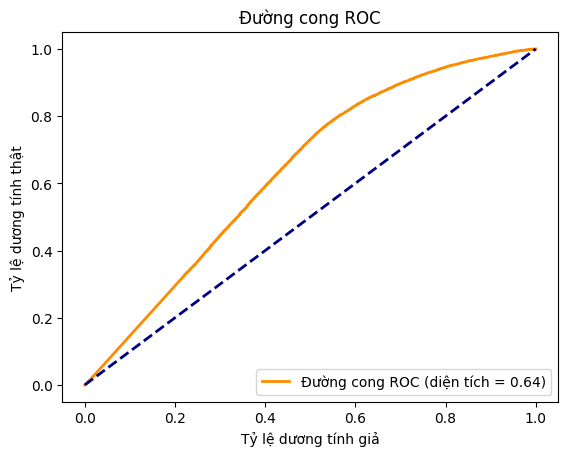

Diện tích dưới đường cong (AUC): 0.64
Ma trận nhầm lẫn:
[[532461      0]
 [ 16514      0]]

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    532461
           1       0.00      0.00      0.00     16514

    accuracy                           0.97    548975
   macro avg       0.48      0.50      0.49    548975
weighted avg       0.94      0.97      0.96    548975


Độ chính xác: 0.97


In [ ]:
# Đánh giá mô hình
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
model.eval()
# Lấy logits từ tập kiểm tra
logits = model(torch.tensor(X_test, dtype=torch.float32))
# Áp dụng hàm sigmoid để chuyển đổi logits thành xác suất
y_scores = torch.sigmoid(logits).detach().numpy()
# Chuyển đổi xác suất thành dự đoán nhị phân
y_pred = (y_scores > 0.5).astype(int)  # Chuyển đổi xác suất thành dự đoán nhị phân

# Tính toán đường cong ROC và AUC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Vẽ đường cong ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Đường cong ROC (diện tích = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tỷ lệ dương tính giả')
plt.ylabel('Tỷ lệ dương tính thật')
plt.title('Đường cong ROC')
plt.legend(loc='lower right')
plt.show()

print(f"Diện tích dưới đường cong (AUC): {roc_auc:.2f}")

# Ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, y_pred)
print("Ma trận nhầm lẫn:")
print(conf_matrix)

# Báo cáo phân loại
class_report = classification_report(y_test, y_pred, zero_division=0)
print("\nBáo cáo phân loại:")
print(class_report)

# Độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print(f"\nĐộ chính xác: {accuracy:.2f}")

### Codeblock 9: Đánh giá mô hình với ODIN

#### **Mục tiêu:**
- Đánh giá hiệu suất của mô hình trên tập kiểm tra bằng cách sử dụng các kỹ thuật ODIN.

#### **Quy trình:**
1. **Thêm nhiễu đầu vào:**
   - Sử dụng gradient để tạo nhiễu (input perturbation).
2. **Áp dụng nhiệt độ scaling:**
   - Điều chỉnh logits bằng siêu tham số nhiệt độ.
3. **Tính toán xác suất:**
   - Chuyển đổi logits thành xác suất dự đoán.
4. **Đánh giá hiệu suất:**
   - Tính các chỉ số như ROC, AUC, ma trận nhầm lẫn, và báo cáo phân loại.
   - Vẽ biểu đồ ROC để trực quan hóa hiệu suất.

#### **Kết quả:**
- Các chỉ số đánh giá hiệu suất của mô hình với kỹ thuật ODIN được tính toán và trực quan hóa.

#### **Điểm khác biệt chính:**
- **Mục tiêu:**
  - Codeblock 9 tập trung vào đánh giá mô hình với kỹ thuật ODIN.
- **Kỹ thuật sử dụng:**
  - Sử dụng input perturbation và temperature scaling.
- **Kết quả:**
  - Hiệu suất mô hình được đánh giá với các chỉ số và biểu đồ ROC.

### Tại sao sử dụng BCEWithLogitsLoss và không cần hàm sigmoid ở lớp cuối cùng?

#### **Giới thiệu về BCEWithLogitsLoss:**
`BCEWithLogitsLoss` là một hàm mất mát đặc biệt được thiết kế cho các bài toán phân loại nhị phân. Điểm nổi bật của hàm này là:

1. **Chuyển đổi logits thành xác suất:**
   - Tự động áp dụng hàm sigmoid để chuyển đổi đầu ra (logits) của mô hình thành xác suất.
2. **Tính toán Binary Cross-Entropy:**
   - Sử dụng xác suất đã chuyển đổi để tính toán hàm mất mát.

#### **Vì sao không cần hàm sigmoid ở lớp cuối cùng?**
- Trong mô hình `ODINModel`, lớp cuối cùng (`fc2`) không sử dụng hàm sigmoid. Điều này là do `BCEWithLogitsLoss` đã bao gồm bước áp dụng sigmoid nội bộ.
- Nếu thêm sigmoid vào lớp cuối cùng, sẽ dẫn đến việc áp dụng sigmoid hai lần, gây ra:
  - **Lỗi tính toán.**
  - **Giảm độ chính xác của mô hình.**

#### **Lợi ích của việc không sử dụng sigmoid ở lớp cuối cùng:**
1. **Ổn định số học:**
   - Việc tính toán sigmoid và cross-entropy trong một bước giúp giảm thiểu các vấn đề về số học (như tràn số hoặc mất mát độ chính xác).
2. **Hiệu suất tốt hơn:**
   - Tránh tính toán sigmoid thủ công giúp tăng hiệu suất và đơn giản hóa mô hình.

#### **Tóm lại:**
- Mô hình không sử dụng hàm sigmoid ở lớp cuối cùng vì `BCEWithLogitsLoss` đã xử lý bước này.
- Khi cần xác suất đầu ra (như trong đánh giá hoặc dự đoán), bạn có thể áp dụng hàm sigmoid thủ công lên logits.

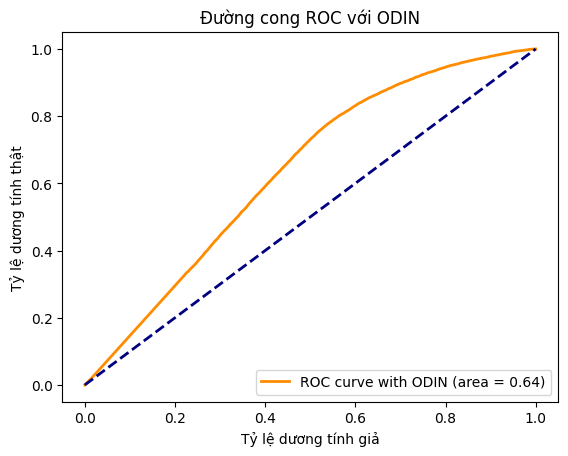

AUC with ODIN: 0.64
Ma trận nhầm lẫn với ODIN:
[[532461      0]
 [ 16514      0]]

Báo cáo phân loại với ODIN:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    532461
           1       0.00      0.00      0.00     16514

    accuracy                           0.97    548975
   macro avg       0.48      0.50      0.49    548975
weighted avg       0.94      0.97      0.96    548975


Độ chính xác với ODIN: 0.97


In [ ]:
# Các sửa đổi cụ thể cho phương pháp ODIN
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable

# Hàm áp dụng nhiệt độ scaling
def apply_temperature_scaling(logits, temperature):
    # Chia logits cho giá trị nhiệt độ để điều chỉnh
    return logits / temperature

# Hàm thêm nhiễu đầu vào
def add_input_perturbation(model, inputs, epsilon, temperature):
    # Đặt đầu vào thành biến có thể tính gradient
    inputs = Variable(inputs, requires_grad=True)
    # Tính toán logits từ mô hình
    logits = model(inputs)
    # Áp dụng nhiệt độ scaling cho logits
    scaled_logits = apply_temperature_scaling(logits, temperature)
    dummy_loss = torch.sum(logits)
    # Reset gradient của mô hình
    model.zero_grad()
    # Tính gradient của dummy loss đối với đầu vào
    dummy_loss.backward()
    gradient = inputs.grad.data
    # Thêm nhiễu vào đầu vào dựa trên dấu của gradient
    perturbed_inputs = inputs + epsilon * gradient.sign()
    return perturbed_inputs


# Đánh giá mô hình với các sửa đổi ODIN
temperature = 1000  # Siêu tham số cho nhiệt độ scaling
epsilon = 0.002  # Siêu tham số cho nhiễu đầu vào
model.eval()
# Thêm nhiễu vào tập kiểm tra
def add_input_perturbation_odin(model, inputs, epsilon):
    # Đặt đầu vào thành biến có thể tính gradient
    inputs = Variable(inputs, requires_grad=True)
    # Tính toán logits từ mô hình
    logits = model(inputs)
    dummy_loss = torch.sum(logits) # Tối đa hóa logit
    # Reset gradient của mô hình
    model.zero_grad()
    # Tính gradient của dummy loss đối với đầu vào
    dummy_loss.backward()
    gradient = inputs.grad.data
    # Thêm nhiễu vào đầu vào dựa trên dấu của gradient
    perturbed_inputs = inputs + epsilon * gradient.sign()
    return perturbed_inputs


# Đánh giá với ODIN
temperature = 1000  # Siêu tham số cho nhiệt độ scaling
epsilon = 0.002  # Siêu tham số cho nhiễu đầu vào

# Tính toán logits cho dữ liệu kiểm tra gốc
original_logits = model(torch.tensor(X_test, dtype=torch.float32))

# Thêm nhiễu vào dữ liệu kiểm tra gốc
perturbed_X_test_odin = add_input_perturbation_odin(model, torch.tensor(X_test, dtype=torch.float32), epsilon)

# Tính toán logits cho dữ liệu đã thêm nhiễu
perturbed_logits = model(perturbed_X_test_odin)

# Áp dụng nhiệt độ scaling cho logits của dữ liệu đã thêm nhiễu
scaled_perturbed_logits = apply_temperature_scaling(perturbed_logits, temperature)

# Chuyển đổi logits đã được scale thành xác suất (điểm ODIN)
odin_scores = torch.sigmoid(scaled_perturbed_logits).detach().numpy()

# Đối với các chỉ số đánh giá như ROC và AUC, chúng ta sử dụng điểm ODIN.
y_scores = odin_scores

# Chuyển đổi điểm ODIN thành dự đoán nhị phân (sử dụng ngưỡng, ví dụ: 0.5)
y_pred = (y_scores > 0.5).astype(int)

# Tính toán đường cong ROC và AUC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Vẽ đường cong ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve with ODIN (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tỷ lệ dương tính giả')
plt.ylabel('Tỷ lệ dương tính thật')
plt.title('Đường cong ROC với ODIN')
plt.legend(loc='lower right')
plt.show()

print(f"AUC with ODIN: {roc_auc:.2f}")

# Ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, y_pred)
print("Ma trận nhầm lẫn với ODIN:")
print(conf_matrix)

# Báo cáo phân loại
class_report = classification_report(y_test, y_pred, zero_division=0)
print("\nBáo cáo phân loại với ODIN:")
print(class_report)

# Độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print(f"\nĐộ chính xác với ODIN: {accuracy:.2f}")